In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os,glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from datatools.metmast import EddyPro_full_output

# Stability Analysis: Hybrid-Wind method
from Basu2018 - A simple recipe for estimating atmospheric stability solely based on surface-layer wind speed profile (https://doi.org/10.1002/we.2203)

In [4]:
from mmctools.stability import HybridWindEstimator
from mmctools.stability import BusingerDyer as psi_m

/Users/equon/a2e-mmc/mmctools/stability.py:24: RuntimeWarning: invalid value encountered in power
  x = (1. - 16*z_L)**0.25


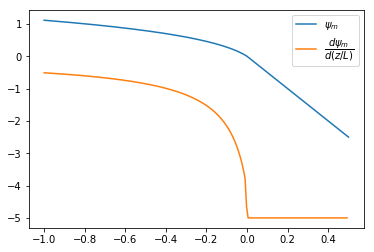

In [5]:
z_L = np.linspace(-1,0.5,201)
corr = psi_m(z_L)
plt.plot(z_L,corr,label=r'$\psi_m$')
plt.plot(z_L[:-1],np.diff(corr)/np.diff(z_L),label=r'$\dfrac{d\psi_m}{d(z/L)}$')
plt.legend()

## read WFIP2 Physics Site test data

In [6]:
datadir = {
    'met.z19.b0': '/Users/equon/WFIP2/PS02/met.z19.b0',
    'met.z21.b0': '/Users/equon/WFIP2/PS06/met.z21.b0',
}
dataheights = {
    'met.z19.b0': [3,10,17],
    'met.z21.b0': [3,10,21],
}
suffix = 'full_output.csv'

In [7]:
varlist = [
    'wind_speed',
    'wind_dir',
    #'sonic_temperature',
    #'TKE',
    #'u*',
    #'cov(w/u)',
    #'w/ts_cov',
    '(z-d)/L'
]

In [8]:
#dap_name,dap_id = 'PS02','met.z19.b0'
dap_name,dap_id = 'PS06','met.z21.b0'

In [9]:
%%time
dflist = []
for height in dataheights[dap_id]:
    globstr = os.path.join(datadir[dap_id],'{:s}.*.son{:02d}m.{:s}'.format(dap_id,int(height),suffix))
    filelist = glob.glob(globstr)
    df = EddyPro_full_output(*filelist,columns=varlist)
    df = df.sort_index()
    df['height'] = height
    print(dap_id,': read',len(filelist),'files for datetimes from',df.index[0],'to',df.index[-1])
    dflist.append(df)
df = pd.concat(dflist)

met.z21.b0 : read 30 files for datetimes from 2016-11-01 00:15:00 to 2016-12-01 00:00:00
met.z21.b0 : read 30 files for datetimes from 2016-11-01 00:15:00 to 2016-12-01 00:00:00
met.z21.b0 : read 30 files for datetimes from 2016-11-01 00:15:00 to 2016-12-01 00:00:00
CPU times: user 564 ms, sys: 51.8 ms, total: 615 ms
Wall time: 744 ms


## estimate Obukhov length

In [10]:
est = HybridWindEstimator()

In [11]:
est.read_pandas(df)

Found heights: [ 3 10 21]


In [12]:
# unsolvable stable/unstable cases with fsolve: 747 877
# unsolvable stable/unstable cases with brentq: 0 0
#%time invL = est.calculate_opt(psi_m)
%time invL,err = est.calculate_opt(psi_m,error_output=True)
print('max error:',np.nanmax(np.abs(err)))

/Users/equon/a2e-mmc/mmctools/stability.py:24: RuntimeWarning: invalid value encountered in double_scalars
  x = (1. - 16*z_L)**0.25


CPU times: user 823 ms, sys: 54.5 ms, total: 877 ms
Wall time: 1.16 s
max error: 1.0165202013467933e-11


In [13]:
np.nanmin(invL),np.nanmax(invL),np.count_nonzero(np.isnan(invL)),len(invL)

(-0.6865182448393568, 0.9732109788930369, 1087, 2880)

## compare against obs

In [14]:
window = '2h'

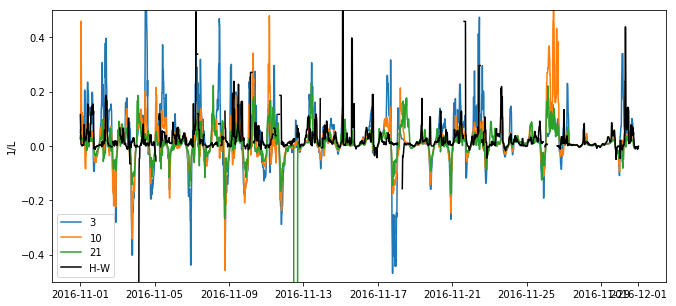

In [21]:
fig,ax = plt.subplots(figsize=(11,5))
for height in est.heights:
    z_L = df.loc[df['height']==height,['(z-d)/L']]
    z_L = z_L.rolling(window).median()
    ax.plot(z_L.index,z_L['(z-d)/L']/height,label=height)
invL_med = pd.Series(index=z_L.index,data=invL).rolling(window).median()
ax.plot(z_L.index,invL_med,'k-',label='H-W')
ax.set_ylim((-.5,.5))
ax.set_xlabel('')
ax.set_ylabel('1/L')
ax.legend()

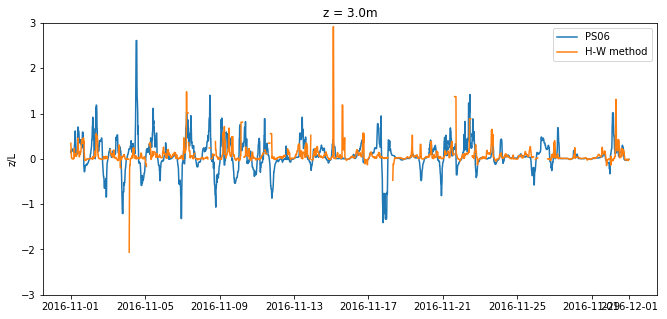

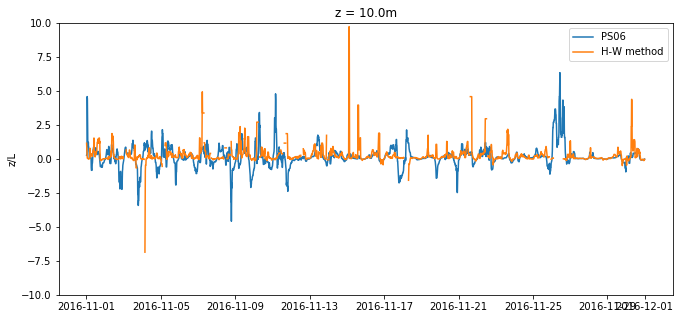

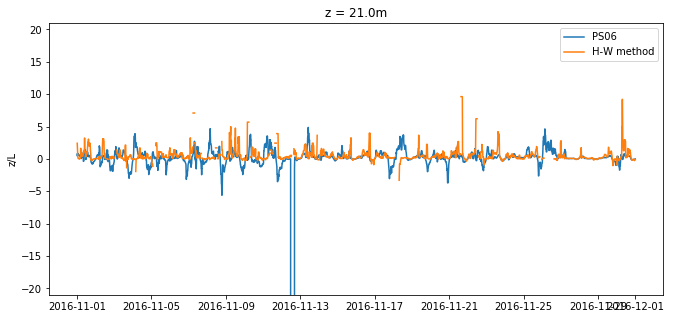

In [20]:
for height in est.heights:
    z_L = df.loc[df['height']==height,['(z-d)/L']]
    z_L['est'] = height*invL
    out_of_range = (z_L['est'] > 10) | (z_L['est'] < -10)
    z_L.loc[out_of_range,'est'] = np.nan
    z_L = z_L.rolling(window).median()

    fig,ax = plt.subplots(figsize=(11,5))
    ax.plot(z_L.index,z_L['(z-d)/L'],label=dap_name)
    ax.plot(z_L.index,z_L['est'],label='H-W method')
    ax.set_ylim((-height,height))
    ax.set_xlabel('')
    ax.set_ylabel('z/L')
    ax.legend()
    ax.set_title('z = {:.1f}m'.format(height))

(-0.4, 0.4)

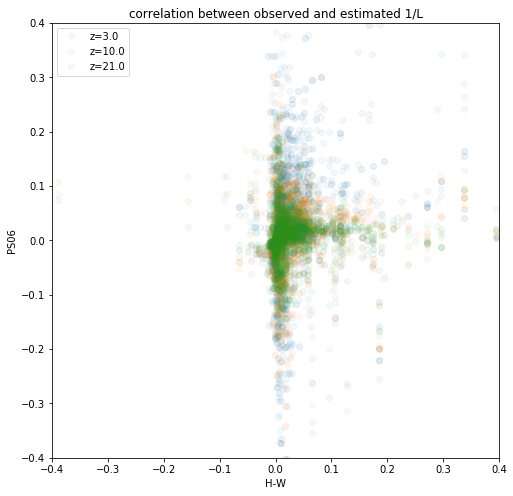

In [18]:
fig,ax = plt.subplots(figsize=(8,8))
invL_med = pd.Series(index=z_L.index,data=invL).rolling(window).median()
for height in est.heights:
    z_L = df.loc[df['height']==height,['(z-d)/L']]
    z_L = z_L.rolling(window).median()
    ax.plot(invL_med,z_L['(z-d)/L']/height,'o',alpha=0.05,label='z={:.1f}'.format(height))
ax.set_xlabel('H-W')
ax.set_ylabel(dap_name)
ax.set_title('correlation between observed and estimated 1/L')
ax.legend()
ax.set_xlim((-.4,.4))
ax.set_ylim((-.4,.4))
#ax.axis('equal')